In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import gensim
import keras
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image

np.random.seed(1003)

Using TensorFlow backend.


### Python 3.6.1

In [3]:
gensim.__version__

'3.1.0'

In [4]:
tf.__version__

'1.3.0'

In [5]:
keras.__version__

'2.0.8'

### Specify Hyperparameters

In [6]:
# Specify the folder locations
W2V_DIR = '/collection/hpallika/deeplearning/research_work/word_embeddings/GoogleNews-vectors-negative300.bin'
# W2V_DIR = 'data/w2v_300d_snli_data.pkl'
DATA_DIR = 'data/'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 30
MAX_VOCAB_SIZE = 20000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 32
N_EPOCHS = 10

### Load Data

In [7]:
# Read the text files of positive and negative sentences
with open(DATA_DIR+'rt-polarity.neg', 'r', errors='ignore') as f:
    neg = f.readlines()
    
with open(DATA_DIR+'rt-polarity.pos', 'r', errors='ignore') as f:
    pos = f.readlines()

In [8]:
print('Number of negative sentences:', len(neg))
print('Number of positive sentences:', len(pos))

Number of negative sentences: 5331
Number of positive sentences: 5331


In [9]:
# Create a dataframe to store the sentence and polarity as 2 columns
df = pd.DataFrame(columns=['sentence', 'polarity'])
df['sentence'] = neg + pos
df['polarity'] = [0]*len(neg) + [1]*len(pos)
df = df.sample(frac=1, random_state=10) # Shuffle the rows
df.reset_index(inplace=True, drop=True)

In [10]:
df.head(10)

,sentence,polarity
0,"funny , somber , absurd , and , finally , achi...",1
1,"moore's complex and important film is also , b...",1
2,[scherfig] has made a movie that will leave yo...,1
3,the powerful success of read my lips with such...,1
4,the film is filled with humorous observations ...,1
5,thanks to haynes' absolute control of the film...,1
6,really does feel like a short stretched out to...,0
7,has a customarily jovial air but a deficit of ...,0
8,"as teen movies go , "" orange county "" is a ref...",1
9,"[a] soulless , stupid sequel . . . \n",0


In [11]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq = [text_to_word_sequence(sent) for sent in df['sentence']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

90th Percentile Sentence Length: 31.0


<code>Since only 10 percent of the sentences have more than 31 words, we should be safe using MAX_SENT_LEN as 30

In [12]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 19180


<code>The number of unique words are less than our MAX_VOCAB_SIZE limit

In [ ]:
tokenizer.word_index

In [14]:
# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = df['polarity']

In [15]:
X[:3]

array([[  63, 1961, 1962,    3,  573, 3247,  479, 3248,    6,    2,  398,
        2125,  251,    4,  464,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [2126,  524,    3,  596,   13,    6,  138,  429,    9,   39,   23,
        3249,  184,    2,  639,    3, 7101,   41,  114,  112,   70,   54,
         776,  204,   43,    0,    0,    0,    0,    0],
       [4503,   29,   87,    2,   18,    8,   55,  430,   22, 2127,   26,
           1, 1354,  439,  185,    1,  291, 1355, 1660,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.1)

In [17]:
X_train.shape

(9595, 30)

In [18]:
%%time
# Load the word2vec embeddings 
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)
# embeddings = gensim.models.Word2Vec.load(W2V_DIR)

CPU times: user 28.2 s, sys: 2.33 s, total: 30.6 s
Wall time: 30.1 s


In [19]:
print('Number of words in this pre-trained w2v model:', len(embeddings.vocab))
print('Dimension of w2v:', embeddings.vector_size)

Number of words in this pre-trained w2v model: 3000000
Dimension of w2v: 300


In [20]:
embeddings.most_similar('canada')

[('australia', 0.7359464168548584),
 ('usa', 0.7136157751083374),
 ('canadian', 0.6989885568618774),
 ('uk', 0.6821741461753845),
 ('india', 0.6490967869758606),
 ('microsoft', 0.628359317779541),
 ('malaysia', 0.621403694152832),
 ('turbotax', 0.6093018054962158),
 ('mexico', 0.6087307929992676),
 ('ireland', 0.6055780053138733)]

In [21]:
embeddings.most_similar('elephant')

[('elephants', 0.7806671857833862),
 ('rhino', 0.6780353784561157),
 ('pachyderm', 0.6761020421981812),
 ('tiger', 0.6681443452835083),
 ('rhinoceros', 0.6430982351303101),
 ('tigers', 0.6049249172210693),
 ('hippo', 0.603914737701416),
 ('gorilla', 0.5969827175140381),
 ('giraffe', 0.593181312084198),
 ('rhinos', 0.5868902802467346)]

In [22]:
embeddings.doesnt_match('ronaldo messi torres trump'.split(' '))

'trump'

In [23]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

### Keras Sequential API

In [24]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True))

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         5754300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 5,974,077
Trainable params: 5,974,077
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 22s - loss: 0.4982 - acc: 0.7507 - val_loss: 0.4128 - val_acc: 0.8088
Epoch 2/10
9595/9595 [==============================] - 18s - loss: 0.2705 - acc: 0.8928 - val_loss: 0.4367 - val_acc: 0.7882
Epoch 3/10
9595/9595 [==============================] - 19s - loss: 0.1164 - acc: 0.9576 - val_loss: 0.6114 - val_acc: 0.7948
Epoch 4/10
9595/9595 [==============================] - 20s - loss: 0.0455 - acc: 0.9847 - val_loss: 0.6859 - val_acc: 0.7919
Epoch 5/10
9595/9595 [==============================] - 21s - loss: 0.0272 - acc: 0.9911 - val_loss: 0.8921 - val_acc: 0.7863
Epoch 6/10
9595/9595 [==============================] - 21s - loss: 0.0126 - acc: 0.9959 - val_loss: 1.2126 - val_acc: 0.7666
Epoch 7/10
9595/9595 [==============================] - 21s - loss: 0.0088 - acc: 0.9974 - val_loss: 1.1048 - val_acc: 0.7751
Epoch 8/10
9595/9595 [==============================] - 21s - loss: 0.

In [31]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=BATCH_SIZE)

1067/1067 [==============================] - 0s     


In [32]:
print("Accuracy on Test Set = {0:4.3f}".format(acc))

Accuracy on Test Set = 0.777


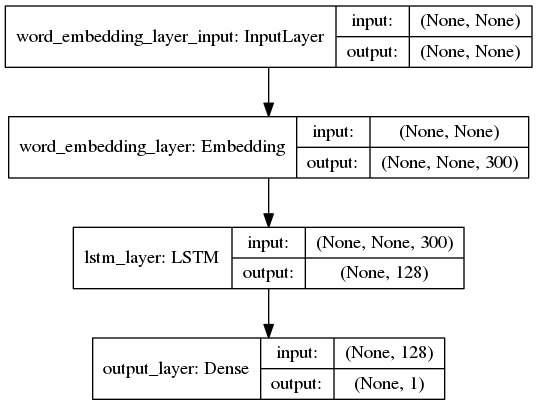

In [33]:
plot_model(model, to_file='basic_lstm_classifier.png', show_layer_names=True, show_shapes=True)
Image('basic_lstm_classifier.png')

<code>Modify the network by adding two more Dense layers with Batch-Normalization and Dropouts:

In [34]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

model.add(Dense(32, name='dense_1'))
# model.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model.add(Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(Activation(activation='relu', name='activation_1'))

model.add(Dense(8, name='dense_2'))
# model.add(BatchNormalization(name='bn_2'))
model.add(Dropout(rate=0.3, name='dropout_2'))
model.add(Activation(activation='relu', name='activation_2'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         5754300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
__________

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 22s - loss: 0.5763 - acc: 0.7061 - val_loss: 0.4798 - val_acc: 0.7563
Epoch 2/10
9595/9595 [==============================] - 21s - loss: 0.4929 - acc: 0.7762 - val_loss: 0.4452 - val_acc: 0.7826
Epoch 3/10
9595/9595 [==============================] - 21s - loss: 0.4634 - acc: 0.7917 - val_loss: 0.4570 - val_acc: 0.7854
Epoch 4/10
9595/9595 [==============================] - 21s - loss: 0.4319 - acc: 0.8101 - val_loss: 0.4359 - val_acc: 0.7863
Epoch 5/10
9595/9595 [==============================] - 21s - loss: 0.4054 - acc: 0.8201 - val_loss: 0.4572 - val_acc: 0.7732
Epoch 6/10
9595/9595 [==============================] - 21s - loss: 0.3823 - acc: 0.8351 - val_loss: 0.4475 - val_acc: 0.7948
Epoch 7/10
9595/9595 [==============================] - 21s - loss: 0.3502 - acc: 0.8508 - val_loss: 0.4525 - val_acc: 0.7891
Epoch 8/10
9595/9595 [==============================] - 21s - loss: 0.

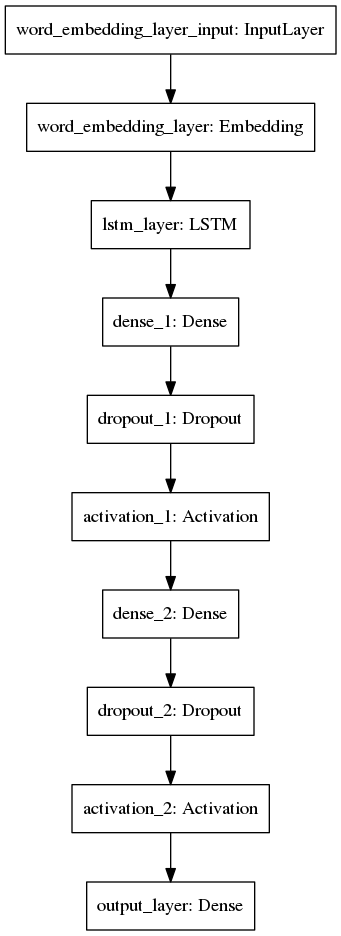

In [37]:
plot_model(model, to_file='modified_lstm_classifier.png', show_layer_names=True)
Image('modified_lstm_classifier.png')